## Regularization - Data Science Portfolio - Maximilian Koch

**Dataset**: Spotify songs<br>
**Target variable**: Predicting a songs popularity<br>
**Features**: Track information, artist genres<br>
**Techniques applied**: Linear regression, ridge regularization, Grid Search optimization<br>


Ridge regularization is a way to prevent overfitting in linear models by adding a penalty term to the loss function.
The loss function of a linear model is given by $RSS(\beta) = \sum_{i=1}^{n} (y_i - x_i^T\beta)^2$.
The cost function for Ridge Regressio is then $J(\beta) = \sum_{i=1}^{n} (y_i - x_i^T\beta)^2 + \alpha \sum_{j=1}^{p} \beta_j^2$,
thus the linear model loss added by a penalty term with the regularization parameter $\alpha$.

To demonstrate the effect of regularization over purely using a linear regression,
I am using this dataset containing 10,000 Spotify songs, which contains various additional information about each track:
https://www.kaggle.com/datasets/joebeachcapital/top-10000-spotify-songs-1960-now

In this notebook, I will:

- Load and preprocess the Spotify song dataset.
- Implement Linear Regression.
- Implement Ridge Regression with the cost function shown above.
- Use Grid Search to optimize the regularization parameter α.
- Analyze posterior distributions of model coefficients
- Compare model performance

### Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import resample

df = pd.read_csv('datasets/regularization_dataset.csv')
df.head(5)

,Track URI,Track Name,Artist URI(s),Artist Name(s),Album URI,Album Name,Album Artist URI(s),Album Artist Name(s),Album Release Date,Album Image URL,...,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Album Genres,Label,Copyrights
0,spotify:track:0vNPJrUrBnMFdCs8b2MTNG,Fader,spotify:artist:4W48hZAnAHVOC2c8WH8pcq,The Temper Trap,spotify:album:0V59MMtgoruvEqMv18KAOH,Conditions (Tour Edition),spotify:artist:4W48hZAnAHVOC2c8WH8pcq,The Temper Trap,2009,https://i.scdn.co/image/ab67616d0000b273f86ae8...,...,0.0353,0.000101,0.690000,0.0752,0.158,134.974,4.0,NaN,Liberation Records,"C 2010 Liberation Music, P 2010 Liberation Music"
1,spotify:track:0NpvdCO506uO58D4AbKzki,Sherry,spotify:artist:6mcrZQmgzFGRWf7C0SObou,Frankie Valli & The Four Seasons,spotify:album:0NUEQILaBzavnzcMEs4buZ,The Very Best of Frankie Valli & The 4 Seasons,spotify:artist:6mcrZQmgzFGRWf7C0SObou,Frankie Valli & The Four Seasons,2003-01-14,https://i.scdn.co/image/ab67616d0000b273b96c21...,...,0.0441,0.626000,0.000000,0.1130,0.734,117.562,4.0,NaN,Rhino,C © 2004 Bob Gaudio & Frankie Valli d/b/a The ...
2,spotify:track:1MtUq6Wp1eQ8PC6BbPCj8P,I Took A Pill In Ibiza - Seeb Remix,"spotify:artist:2KsP6tYLJlTBvSUxnwlVWa, spotify...","Mike Posner, Seeb",spotify:album:1Tz3Ai1guEFf4hV3d9i17K,"At Night, Alone.",spotify:artist:2KsP6tYLJlTBvSUxnwlVWa,Mike Posner,2016-05-06,https://i.scdn.co/image/ab67616d0000b273a19be7...,...,0.1110,0.035300,0.000008,0.0843,0.710,101.969,4.0,NaN,"Monster Mountain, LLC / Island","C © 2016 Island Records, a division of UMG Rec..."
3,spotify:track:59lq75uFIqzUZcgZ4CbqFG,Let Go for Tonight,spotify:artist:7qRll6DYV06u2VuRPAVqug,Foxes,spotify:album:5AQ7uKRSpAv7SNUl4j24ru,Glorious (Deluxe),spotify:artist:7qRll6DYV06u2VuRPAVqug,Foxes,2014-05-12,https://i.scdn.co/image/ab67616d0000b273ae5c7d...,...,0.0632,0.042900,0.000002,0.3260,0.299,140.064,4.0,NaN,Sign Of The Times Records,P (P) 2014 Sign Of The Times Limited under exc...
4,spotify:track:7KdcZQ3GJeGdserhK61kfv,The Way I Want To Touch You,spotify:artist:7BEfMxbaqx6dOpbtlEqScm,Captain & Tennille,spotify:album:3GUxesVyOehInaxJyCTh6d,Love Will Keep Us Together,spotify:artist:7BEfMxbaqx6dOpbtlEqScm,Captain & Tennille,1975-01-01,https://i.scdn.co/image/ab67616d0000b273e21a28...,...,0.0248,0.624000,0.000112,0.3430,0.597,111.290,4.0,NaN,A&M,"C © 1975 A&M Records, P This Compilation ℗ 197..."


The dataset contains information about the track, it's publishing context and measures of the track, such as acousticness.
Additionally, there is a column containing the genres of the song, on which I will focus.

In [2]:
df['Artist Genres'].head(5)

0                 indietronica,modern rock,shimmer pop
1    adult standards,bubblegum pop,doo-wop,lounge,n...
2            dance pop,pop,pop dance,pop rap,pop dance
3                       electropop,metropopolis,uk pop
4                     mellow gold,soft rock,yacht rock
Name: Artist Genres, dtype: object

The genres of a song are stored as a list. In the following, I will one-hot-encode all of the genres to use the genres as prediction for a songs success.

In [2]:
num_only = df.select_dtypes(include='number')
num_only['Artist Genres'] = df['Artist Genres']
def list_split(x): #genres of artist are in a list
    try:
        return list(set(x.split(',')))
    except AttributeError:
        return ''
df['Artist Genres'] = df['Artist Genres'].apply(list_split)
df = df.drop(columns=['Album Genres','Label','Copyrights','Added At','Added By','ISRC','Track Preview URL',
'Album Image URL','Album Artist Name(s)','Album Name','Album URI','Artist Name(s)','Artist URI(s)','Track Name','Track URI',
'Album Artist URI(s)','Album Release Date']).dropna()
print('Colums before genre encoding:',len(df.columns))
one_hot_encoded = pd.get_dummies(df['Artist Genres'].explode()).groupby(level=0).sum()
df = pd.concat([df, one_hot_encoded], axis=1)
df = df.drop('Artist Genres',axis=1)
print('Columns after genre enconding:',len(df.columns))

Colums before genre encoding: 18
Columns after genre enconding: 925


The genre one-hot encoding let to many hundreds of categories. With Lasso regression several of these genre categories would shrink to zero, and although that could lead to a better model performance than with Ridge regression, a song's popularity is partially defined by its genres, thus removing some of these genres would remove some of the relevant data. Therefore I will be using a Ridge regression here, with a baseline comparison to a Linear Model.

### Linear Model

Predicting the popularity of a song, which is measured with a score from 0 to 100.

In [5]:
X = df.drop(['Popularity'], axis=1)
y = df['Popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Baseline model:

In [6]:
ols = LinearRegression()
ols.fit(X_train_scaled, y_train)
y_pred_ols = ols.predict(X_test_scaled)

### Ridge regression

Ridge regression:

In [7]:
param_grid = {'alpha': np.logspace(-3, 5, 100)}

ridge = Ridge()
grid_search = GridSearchCV(ridge, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

best_ridge = grid_search.best_estimator_
y_pred_ridge = best_ridge.predict(X_test_scaled)

In [8]:
from scipy.stats import spearmanr
print('Linear Model RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_ols)))
print('Linear Model r²:',r2_score(y_test, y_pred_ols))
print('Linear Model bias:',np.mean(y_pred_ols-y_test))
print('Linear model spearman:',spearmanr(y_test,y_pred_ols).correlation)
print()
print('Ridge Model RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print('Ridge Model r²:',r2_score(y_test, y_pred_ridge))
print('Ridge Model bias:',np.mean(y_pred_ridge-y_test))
print('Ridge model spearman:',spearmanr(y_test,y_pred_ridge).correlation)

Linear Model RMSE: 621884344829345.0
Linear Model r²: -5.15435468521042e+26
Linear Model bias: -5220127433638.179
Linear model spearman: 0.30680565101331436

Ridge Model RMSE: 26.056861874014043
Ridge Model r²: 0.09510273914326905
Ridge Model bias: 1.1950133805031689
Ridge model spearman: 0.3264419432449181


The linear model's r² is extremely small (-5*10^26) and shows that here a linear model fails. Given that the one-hot encoding resulted in several hundred of binary genre columns with large class imbalances, that is not surprising.
The Ridge model performed better, but can also only explain a smaller part of a track's popularity.

In [9]:
coefs = pd.DataFrame({
    'Feature': X.columns,
    'OLS': ols.coef_,
    'Ridge': best_ridge.coef_
}).sort_values('Ridge', key=abs, ascending=False)

### Coefficient confidence

Bootstraping the coefficients of the linear model:

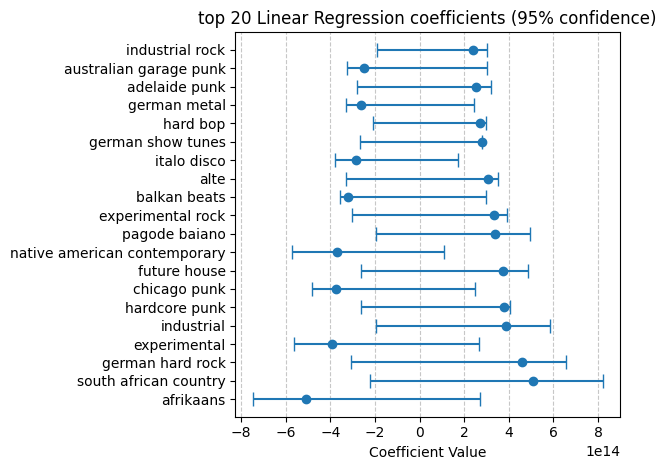

In [10]:
n_bootstraps = 300 #else takes too long
coefs_boot = np.zeros((n_bootstraps, X.shape[1]))

for i in range(n_bootstraps):
    X_resampled, y_resampled = resample(X_train_scaled, y_train)
    model = LinearRegression()
    model.fit(X_resampled, y_resampled)
    coefs_boot[i] = model.coef_

ci_low = np.percentile(coefs_boot, 2.5, axis=0)
ci_high = np.percentile(coefs_boot, 97.5, axis=0)

#plotting top 20 most important features only
sorted_features = coefs.sort_values(by='OLS', key=abs, ascending=False)['Feature'].head(20)


for i, feature in enumerate(sorted_features):
    idx = X.columns.get_loc(feature)
    coef_val = coefs.loc[coefs['Feature'] == feature, 'OLS'].values[0]

    left_error = abs(coef_val - ci_low[idx])
    right_error = abs(ci_high[idx] - coef_val)
    
    plt.errorbar(x=coef_val, y=feature, xerr=np.array([[left_error], [right_error]]), 
                 fmt='o', color='tab:blue', capsize=5)

plt.title('top 20 Linear Regression coefficients (95% confidence)')
plt.xlabel('Coefficient Value')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

For the linear regression model, none of the top 20 coefficients have a significant influence. Additionally, the coefficients tend to be extremely large, which also explains the very large RMSE from above.

Bootstrapping of the Ridge model:

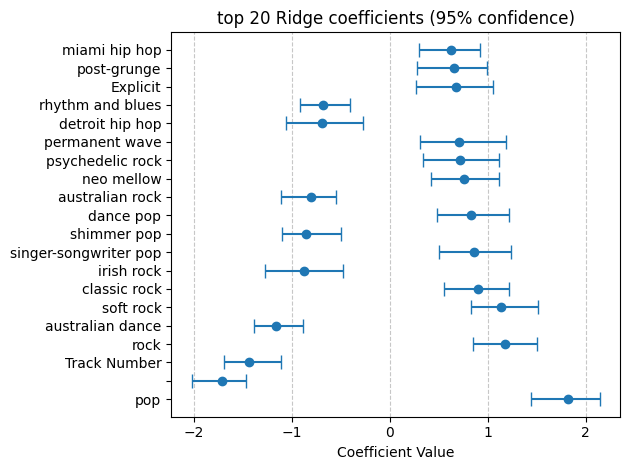

In [11]:
n_bootstraps = 300
coefs_boot = np.zeros((n_bootstraps, X.shape[1]))

for i in range(n_bootstraps):
    X_resampled, y_resampled = resample(X_train_scaled, y_train)
    model = Ridge(alpha=best_ridge.alpha)
    model.fit(X_resampled, y_resampled)
    coefs_boot[i] = model.coef_

ci_low = np.percentile(coefs_boot, 2.5, axis=0)
ci_high = np.percentile(coefs_boot, 97.5, axis=0)

#plotting top 20 most important features only
sorted_features = coefs.sort_values(by='Ridge', key=abs, ascending=False)['Feature'].head(20)

for i, feature in enumerate(sorted_features):
    idx = X.columns.get_loc(feature)
    coef_val = coefs.loc[coefs['Feature'] == feature, 'Ridge'].values[0]
    lower = coef_val - ci_low[idx]
    upper = ci_high[idx] - coef_val
    
    plt.errorbar(x=coef_val,y=feature,xerr=np.array([[lower], [upper]]),fmt='o',
                 color='tab:blue',capsize=5)

plt.title('top 20 Ridge coefficients (95% confidence)')
plt.xlabel('Coefficient Value')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Here the coefficients are much more significant as none of their posterior distributions reaches below and above 0.
Also, here not only genres, but also whether a song contains explicit words and it's track number in an album has a significant influence on it's success. For the linear regression only genres were in the top features.

Thus, overall the Ridge model performs much better than the linear model, as it effectively shrinks the impact of the large number of genres.